In [ ]:
#default_exp interpret.interpret

# Analyse Model Confidence

This module provides a replacement for fastai's [`ClassificationInterpretation`](https://dev.fast.ai/interpret) class in a few ways:
* Store predictions in a `pandas.DataFrame` object
* Prediction confidence plots
* Per label prediction accuracy plot
* More legible `plot_top_losses`

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [ ]:
#export
from fastai.vision.all import *
from fastai.metrics import *
import PIL

In [ ]:
#hide
from nbdev.showdoc import show_doc

In [ ]:
#hide
from cinemanet.train.data_handler import *
from cinemanet.train.helpers import *

warnings.simplefilter('ignore')
dhandler = (
    DataHandler("../../CinemaNet-Training/exports/datasets/shot-lighting-direction.json",
                is_multilabel=True, verbose=False)
    .get_dataset_df('train', 'valid')
    .filter_dataset()
    .setup_dls(batch_size=32)
)

helper = ClassificationHelper(dhandler, '__', save_path="/tmp", antialiased=True)
learn_multi  = helper.get_learner()
_learn = load_learner("../lighting-1.pkl")
learn_multi.model.load_state_dict(_learn.model.state_dict())

<All keys matched successfully>

In [ ]:
#hide
from cinemanet.train.data_handler import *
from cinemanet.train.helpers import *

warnings.simplefilter('ignore')
dhandler = (
    DataHandler("../../CinemaNet-Training/exports/datasets/shot-framing.json",
                is_multilabel=False, verbose=False)
    .get_dataset_df('train-clean', 'valid-clean')
    .filter_dataset()
    .setup_dls(batch_size=32)
)

helper = ClassificationHelper(dhandler, '__', save_path="/tmp", antialiased=True)
learn  = helper.get_learner()
_learn = load_learner("../framing-1.pkl")
learn.model.load_state_dict(_learn.model.state_dict())

<All keys matched successfully>

### Setup

For some context, the model I'm using here is a single-label classifier with a softmax activation, and has 9 classes:

`01-extremewide` <br>
`02-wide` <br>
`03-long` <br>
`04-medium-long` <br>
`05-medium` <br>
`06-medium-close-up` <br>
`07-closeup` <br>
`08-extreme-close-up` <br>
`09-zz-NA` <br>

In [ ]:
#export
from fastai_amalgam.utils import *
from fastai_amalgam.show_data import *

In [ ]:
learn.dls.set_font_path("../fonts/DIN Alternate Bold.ttf")
learn_multi.dls.set_font_path("../fonts/DIN Alternate Bold.ttf")

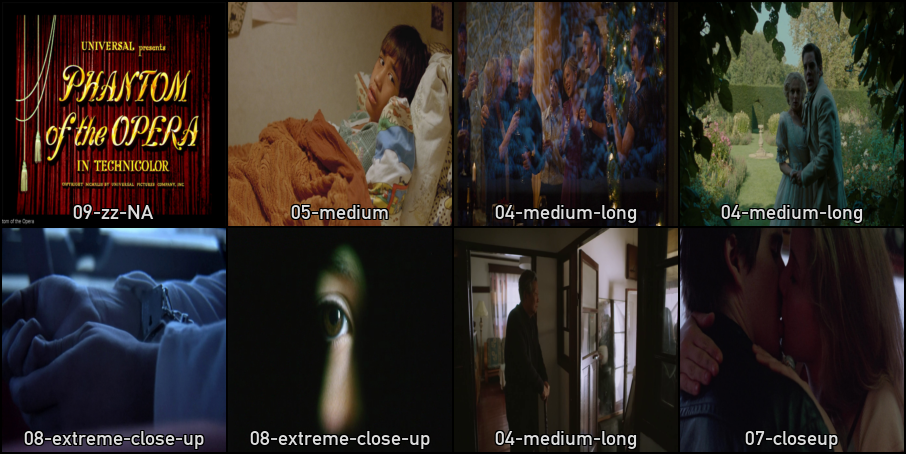

In [ ]:
learn.dls.show_batch_grid(n=8)

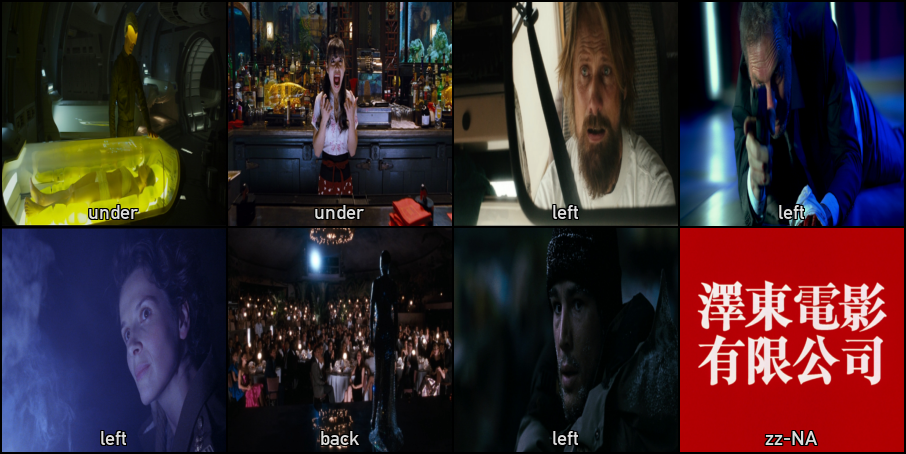

In [ ]:
learn_multi.dls.show_batch_grid(n=8)

## ClassificationInterpretationEx

In [ ]:
#export
import fastai

def _get_truths(vocab, label_idx, is_multilabel):
    if is_multilabel:
          return ';'.join([vocab[i] for i in torch.where(label_idx==1)][0])
    else: return vocab[label_idx]

class ClassificationInterpretationEx(ClassificationInterpretation):
    """
    Extend fastai2's `ClassificationInterpretation` to analyse model predictions in more depth
    See:
      * self.preds_df
      * self.plot_label_confidence()
      * self.plot_confusion_matrix()
      * self.plot_accuracy()
      * self.get_fnames()
      * self.plot_top_losses_grid()
      * self.print_classification_report()
    """
    def __init__(self, dl, inputs, preds, targs, decoded, losses):
        super().__init__(dl, inputs, preds, targs, decoded, losses)
        self.vocab = self.dl.vocab
        if is_listy(self.vocab): self.vocab = self.vocab[-1]
        if self.targs.__class__ == fastai.torch_core.TensorMultiCategory:
              self.is_multilabel = True
        else: self.is_multilabel = False
        self.compute_label_confidence()
        self.determine_classifier_type()
    
    def determine_classifier_type(self):
        if self.targs[0].__class__==fastai.torch_core.TensorCategory:
            self.is_multilabel = False
        if self.targs[0].__class__==fastai.torch_core.TensorMultiCategory:
            self.is_multilabel = True
            self.thresh = self.dl.loss_func.thresh
    
    def compute_label_confidence(self, df_colname:Optional[str]="fnames"):
        """
        Collate prediction confidence, filenames, and ground truth labels
        in DataFrames, and store them as class attributes
        `self.preds_df` and `self.preds_df_each`
        
        If the `DataLoaders` is constructed from a `pd.DataFrame`, use
        `df_colname` to specify the column name with the filepaths
        """
        if not isinstance(self.dl.items, pd.DataFrame):
            self._preds_collated = [
                #(item, self.dl.vocab[label_idx], *preds.numpy()*100)\
                (item, _get_truths(self.dl.vocab, label_idx, self.is_multilabel), *preds.numpy()*100)\
                for item,label_idx,preds in zip(self.dl.items,
                                                self.targs,
                                                self.preds)
            ]
        ## need to extract fname from DataFrame
        elif isinstance(self.dl.items, pd.DataFrame):
            self._preds_collated = [
                #(item[df_colname], self.dl.vocab[label_idx], *preds.numpy()*100)\
                (item[df_colname], _get_truths(self.dl.vocab, label_idx, self.is_multilabel), *preds.numpy()*100)\
                for (_,item),label_idx,preds in zip(self.dl.items.iterrows(),
                                                self.targs,
                                                self.preds)
            ]        

        self.preds_df       = pd.DataFrame(self._preds_collated, columns = ['fname','truth', *self.dl.vocab])
        self.preds_df.insert(2, column='loss', value=self.losses.numpy())
        
        if self.is_multilabel: return # preds_df_each doesnt make sense for multi-label
        self._preds_df_each = {l:self.preds_df.copy()[self.preds_df.truth == l].reset_index(drop=True) for l in self.dl.vocab}
        self.preds_df_each  = defaultdict(dict)


        sort_desc = lambda x,col: x.sort_values(col, ascending=False).reset_index(drop=True)
        for label,df in self._preds_df_each.items():
            filt = df[label] == df[self.dl.vocab].max(axis=1)
            self.preds_df_each[label]['accurate']   = df.copy()[filt]
            self.preds_df_each[label]['inaccurate'] = df.copy()[~filt]

            self.preds_df_each[label]['accurate']   = sort_desc(self.preds_df_each[label]['accurate'], label)
            self.preds_df_each[label]['inaccurate'] = sort_desc(self.preds_df_each[label]['inaccurate'], label)
            assert len(self.preds_df_each[label]['accurate']) + len(self.preds_df_each[label]['inaccurate']) == len(df)
        
    def get_fnames(self, label:str,
                   mode:('accurate','inaccurate'),
                   conf_level:Union[int,float,tuple]) -> np.ndarray:
        """
        Utility function to grab filenames of a particular label `label` that were classified
        as per `mode` (accurate|inaccurate).
        These filenames are filtered by `conf_level` which can be above or below a certain
        threshold (above if `mode` == 'accurate' else below), or in confidence ranges
        """
        assert label in self.dl.vocab
        if not hasattr(self, 'preds_df_each'): self.compute_label_confidence()
        df = self.preds_df_each[label][mode].copy()
        if mode == 'accurate':
            if isinstance(conf_level, tuple):       filt = df[label].between(*conf_level)
            if isinstance(conf_level, (int,float)): filt = df[label] > conf_level
        if mode == 'inaccurate':
            if isinstance(conf_level, tuple):       filt = df[label].between(*conf_level)
            if isinstance(conf_level, (int,float)): filt = df[label] < conf_level
        return df[filt].fname.values

In [ ]:
interp       = ClassificationInterpretationEx.from_learner(learn)
interp_multi = ClassificationInterpretationEx.from_learner(learn_multi)

In [ ]:
interp.preds_df.head(2)

,fname,truth,loss,01-extremewide,02-wide,03-long,04-medium-long,05-medium,06-medium-close-up,07-closeup,08-extreme-close-up,09-zz-NA
0,2001__a_space_odyssey__1968__003_cropped.jpg,06-medium-close-up,0.794275,0.010279,0.028512,0.015695,0.029457,0.656558,45.190861,53.375996,0.674003,0.018635
1,2001__a_space_odyssey__1968__008_cropped.jpg,06-medium-close-up,5.130556,0.047301,0.087036,0.231384,0.066522,0.232201,0.591327,2.291630,96.282990,0.169614


In [ ]:
show_doc(ClassificationInterpretationEx.compute_label_confidence)

<h4 id="ClassificationInterpretationEx.compute_label_confidence" class="doc_header"><code>ClassificationInterpretationEx.compute_label_confidence</code><a href="__main__.py#L38" class="source_link" style="float:right">[source]</a></h4>

> <code>ClassificationInterpretationEx.compute_label_confidence</code>(**`df_colname`**:`Optional`\[`str`\]=*`'fnames'`*)

```
Collate prediction confidence, filenames, and ground truth labels
in DataFrames, and store them as class attributes
`self.preds_df` and `self.preds_df_each`

If the `DataLoaders` is constructed from a `pd.DataFrame`, use
`df_colname` to specify the column name with the filepaths
```

`self.preds_df` has (3 + num. labels) columns. <br>
1. `fname` has the path to the file on disk <br>
2. `truth` has the ground truth <br>
3. `loss` <br>
3. The third column onwards contain label confidence for each label (in %)

In [ ]:
interp.preds_df.head()

,fname,truth,loss,01-extremewide,02-wide,03-long,04-medium-long,05-medium,06-medium-close-up,07-closeup,08-extreme-close-up,09-zz-NA
0,2001__a_space_odyssey__1968__003_cropped.jpg,06-medium-close-up,0.794275,0.010279,0.028512,0.015695,0.029457,0.656558,45.190861,53.375996,0.674003,0.018635
1,2001__a_space_odyssey__1968__008_cropped.jpg,06-medium-close-up,5.130556,0.047301,0.087036,0.231384,0.066522,0.232201,0.591327,2.291630,96.282990,0.169614
2,2001__a_space_odyssey__1968__038_cropped.jpg,06-medium-close-up,1.681330,0.730931,10.786359,12.567484,8.616324,17.877941,18.612625,4.766017,22.473766,3.568554
3,2001__a_space_odyssey__1968__041_cropped.jpg,06-medium-close-up,0.128396,0.003820,0.022054,0.010768,0.006982,0.772622,87.950462,10.650743,0.577822,0.004725
4,2001__a_space_odyssey__1968__043_cropped.jpg,06-medium-close-up,2.857214,0.158497,0.432986,1.886084,3.124176,2.371618,5.742850,74.707771,11.379311,0.196710


`self.preds_df_each` is a two-level dictionary.

The keys at the first level are the names of the labels (`self.dl.vocab`) <br>
The second level has two keys -- `'accurate'` and `'inaccurate'`, both of which <br>
store `pd.DataFrame`s sorted in descending order of label confidence

This allows you to quickly find the location to the files based on confidence, and you can easily save these to disk for more detailed perusal and to gain insights on where your model fails

In [ ]:
#hide
assert interp.dl.vocab == interp.preds_df_each.keys()

In [ ]:
interp.preds_df_each['02-wide']['accurate'].head(3)

,fname,truth,loss,01-extremewide,02-wide,03-long,04-medium-long,05-medium,06-medium-close-up,07-closeup,08-extreme-close-up,09-zz-NA
0,aloha__2015__056_cropped.jpg,02-wide,0.000233,0.002799,99.976746,0.017383,0.002745,0.000015,0.000058,0.000025,0.000171,0.000060
1,a_clockwork_orange_34_exercise_yard.png,02-wide,0.000347,0.015065,99.965286,0.017150,0.001307,0.000016,0.000110,0.000084,0.000635,0.000361
2,across_the_universe_621.jpg,02-wide,0.000464,0.026326,99.953552,0.014546,0.003089,0.000095,0.000376,0.000213,0.001681,0.000112


---

### ClassificationInterpretationEx.get_fnames

In [ ]:
show_doc(ClassificationInterpretationEx.get_fnames)

<h4 id="ClassificationInterpretationEx.get_fnames" class="doc_header"><code>ClassificationInterpretationEx.get_fnames</code><a href="__main__.py#L83" class="source_link" style="float:right">[source]</a></h4>

> <code>ClassificationInterpretationEx.get_fnames</code>(**`label`**:`str`, **`mode`**:`('accurate', 'inaccurate')`, **`conf_level`**:`Union`\[`int`, `float`, `tuple`\])

```
Utility function to grab filenames of a particular label `label` that were classified
as per `mode` (accurate|inaccurate).
These filenames are filtered by `conf_level` which can be above or below a certain
threshold (above if `mode` == 'accurate' else below), or in confidence ranges
```

In [ ]:
# return accuratly classified files with accuracy above 85%
interp.get_fnames('02-wide', 'accurate', 99.95)

array(['aloha__2015__056_cropped.jpg',
       'a_clockwork_orange_34_exercise_yard.png',
       'across_the_universe_621.jpg'], dtype=object)

In [ ]:
# return inaccurately classified files with accuracy between 84.1 - 85.2%
interp.get_fnames('02-wide', 'accurate', (84.1, 85.2))

array(['5_dolls_august_mmoon_fivedolls002.jpg',
       'big_lebowski__the__1998__022_cropped.jpg'], dtype=object)

---

### Confusion Matrix

In [ ]:
#export
from palettable.scientific.sequential import Davos_3_r

@patch
def plot_confusion_matrix(self:ClassificationInterpretationEx, normalize=True, title='Confusion matrix', cmap=None, norm_dec=2,
                          plot_txt=True, return_fig=False, dpi=100, figsize=(5,5), **kwargs):
    """
    Plot the confusion matrix

    A near exact replica of fastai's method, with the added option
    of `return_fig`, to be able to save the image to disk and a
    different default colormap
    """
    if self.is_multilabel:
        raise NotImplementedError(f"Confusion matrices for multi-label problems aren't implemented")
    # This function is mainly copied from the sklearn docs
    cm = interp.confusion_matrix()
    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig = plt.figure(dpi=dpi, figsize=figsize, **kwargs)
    if cmap is None: cmap=Davos_3_r.mpl_colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(interp.vocab))
    plt.xticks(tick_marks, interp.vocab, rotation=90)
    plt.yticks(tick_marks, interp.vocab, rotation=0)

    if plot_txt:
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            coeff = f'{cm[i, j]:.{norm_dec}f}' if normalize else f'{cm[i, j]}'
            plt.text(j, i, coeff, horizontalalignment="center", verticalalignment="center", color="white" if cm[i, j] > thresh else "black")

    ax = fig.gca()
    ax.set_ylim(len(interp.vocab)-.5,-.5)

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.grid(False)
    if return_fig: return fig

In [ ]:
show_doc(ClassificationInterpretationEx.plot_confusion_matrix)

<h4 id="ClassificationInterpretationEx.plot_confusion_matrix" class="doc_header"><code>ClassificationInterpretationEx.plot_confusion_matrix</code><a href="__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>ClassificationInterpretationEx.plot_confusion_matrix</code>(**`normalize`**=*`True`*, **`title`**=*`'Confusion matrix'`*, **`cmap`**=*`None`*, **`norm_dec`**=*`2`*, **`plot_txt`**=*`True`*, **`return_fig`**=*`False`*, **`dpi`**=*`100`*, **`figsize`**=*`(5, 5)`*, **\*\*`kwargs`**)

```
Plot the confusion matrix

A near exact replica of fastai's method, with the added option
of `return_fig`, to be able to save the image to disk and a
different default colormap
```

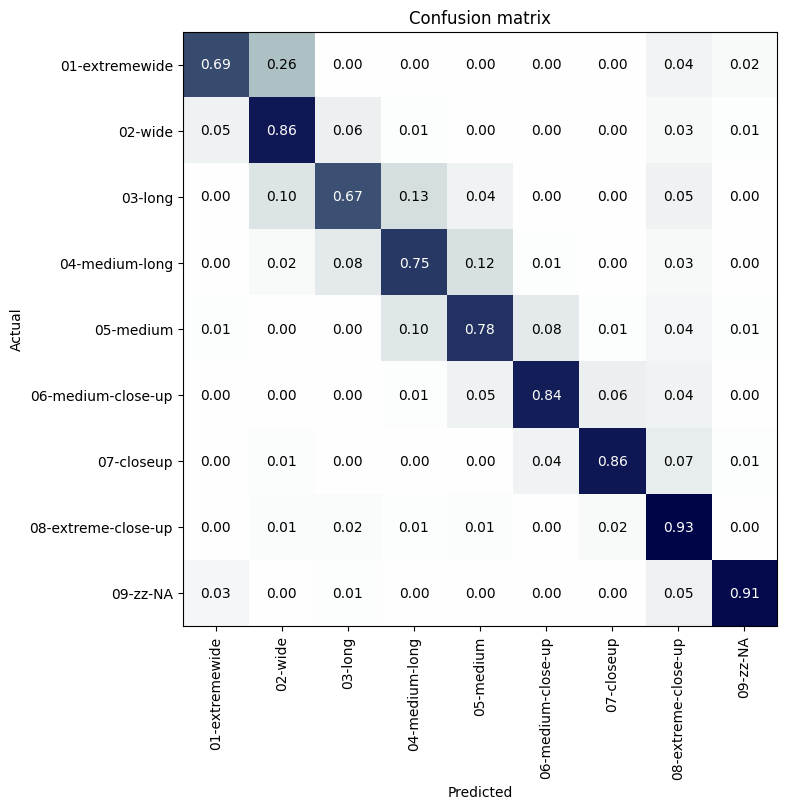

In [ ]:
interp.plot_confusion_matrix(figsize=(8,8))

---

### Plot Accuracy

In [ ]:
#export
@patch
def plot_accuracy(self:ClassificationInterpretationEx, width=0.9, figsize=(6,6), return_fig=False,
                  title='Accuracy Per Label', ylabel='Accuracy (%)', style='ggplot',
                  color='#2a467e', vertical_labels=True):
    'Plot a bar plot showing accuracy per label'
    if not hasattr(self, 'preds_df_each'):
        raise NotImplementedError
    plt.style.use(style)
    if not hasattr(self, 'preds_df_each'): self.compute_label_confidence()
    self.accuracy_dict = defaultdict()

    for label,df in self.preds_df_each.items():
        total = len(df['accurate']) + len(df['inaccurate'])
        self.accuracy_dict[label] = 100 * len(df['accurate']) / total

    fig,ax = plt.subplots(figsize=figsize)

    x = self.accuracy_dict.keys()
    y = [v for k,v in self.accuracy_dict.items()]

    rects = ax.bar(x,y,width,color=color)
    for rect in rects:
        ht = rect.get_height()
        ax.annotate(s  = f"{ht:.02f}",
                    xy = (rect.get_x() + rect.get_width()/2, ht),
                    xytext = (0,3), # offset vertically by 3 points
                    textcoords = 'offset points',
                    ha = 'center', va = 'bottom'
                   )
    ax.set_ybound(lower=0, upper=100)
    ax.set_yticks(np.arange(0,110,10))
    ax.set_ylabel(ylabel)
    ax.set_xticklabels(x, rotation='vertical' if vertical_labels else 'horizontal')
    plt.suptitle(title)
    plt.tight_layout()
    if return_fig: return fig

In [ ]:
show_doc(ClassificationInterpretationEx.plot_accuracy)

<h4 id="ClassificationInterpretationEx.plot_accuracy" class="doc_header"><code>ClassificationInterpretationEx.plot_accuracy</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>ClassificationInterpretationEx.plot_accuracy</code>(**`width`**=*`0.9`*, **`figsize`**=*`(6, 6)`*, **`return_fig`**=*`False`*, **`title`**=*`'Accuracy Per Label'`*, **`ylabel`**=*`'Accuracy (%)'`*, **`style`**=*`'ggplot'`*, **`color`**=*`'#2a467e'`*, **`vertical_labels`**=*`True`*)

```
Plot a bar plot showing accuracy per label
```

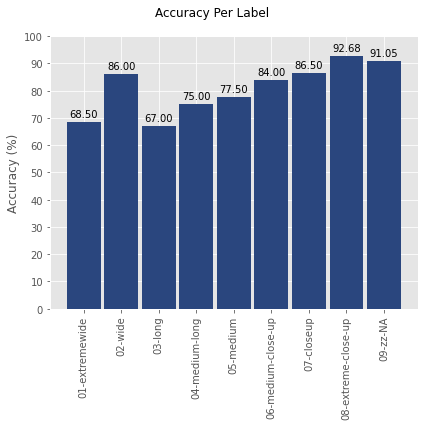

In [ ]:
interp.plot_accuracy()

---

### Plot Label Confidence

In [ ]:
#export
@patch
def plot_label_confidence(self:ClassificationInterpretationEx, bins:int=5, fig_width:int=12, fig_height_base:int=4,
                          title:str='Accurate vs. Inaccurate Predictions Confidence (%) Levels Per Label',
                          return_fig:bool=False, label_bars:bool=True, style='ggplot', dpi=150,
                          accurate_color='#2a467e', inaccurate_color='#dc4a46'):
    """Plot label confidence histograms for each label
    Key Args:
      * `bins`:       No. of bins on each side of the plot
      * `return_fig`: If True, returns the figure that can be easily saved to disk
      * `label_bars`: If True, displays the % of samples that fall into each bar
      * `style`:      A matplotlib style. See `plt.style.available` for more
      * `accurate_color`:   Color of the accurate bars
      * `inaccurate_color`: Color of the inaccurate bars
    """
    if not hasattr(self, 'preds_df_each'):
        raise NotImplementedError
    plt.style.use(style)
    if not hasattr(interp, 'preds_df_each'): interp.compute_label_confidence()
    fig, axes = plt.subplots(nrows = len(interp.preds_df_each.keys()), ncols=2, dpi=dpi,
                             figsize = (fig_width, fig_height_base * len(self.dl.vocab)))
    for i, (label, df) in enumerate(interp.preds_df_each.items()):
        height=0
        # find max height
        for mode in ['inaccurate', 'accurate']:
            len_bins,_ = np.histogram(df[mode][label], bins=bins)
            if len_bins.max() > height: height=len_bins.max()
        
        for mode,ax in zip(['inaccurate', 'accurate'], axes[i]):
            range_ = (50,100) if mode == 'accurate' else (0,50)
            color  = accurate_color if mode == 'accurate' else inaccurate_color
            num,_,patches = ax.hist(df[mode][label], bins=bins, range=range_, rwidth=.95, color=color)
            num_samples = len(df['inaccurate'][label]) + len(df['accurate'][label])
            pct_share   = len(df[mode][label]) / num_samples
            if label_bars:
                for rect in patches:
                    ht = rect.get_height()
                    ax.annotate(s  = f"{round((int(ht) / num_samples) * 100, 1) if ht > 0 else 0}%",
                        xy = (rect.get_x() + rect.get_width()/2, ht),
                        xytext = (0,3), # offset vertically by 3 points
                        textcoords = 'offset points',
                        ha = 'center', va = 'bottom'
                       )
            ax.set_ybound(upper=height + height*0.3)
            ax.set_xlabel(f'{label}: {mode.capitalize()} ({round(pct_share * 100, 2)}%)')
            ax.set_ylabel(f'Num. {mode.capitalize()} ({len(df[mode][label])} of {num_samples})')
    fig.suptitle(title, y=1.0)
    plt.subplots_adjust(top = 0.9, bottom=0.01, hspace=0.25, wspace=0.2)
    plt.tight_layout()
    if return_fig: return fig

In [ ]:
show_doc(ClassificationInterpretationEx.plot_label_confidence)

<h4 id="ClassificationInterpretationEx.plot_label_confidence" class="doc_header"><code>ClassificationInterpretationEx.plot_label_confidence</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>ClassificationInterpretationEx.plot_label_confidence</code>(**`bins`**:`int`=*`5`*, **`fig_width`**:`int`=*`12`*, **`fig_height_base`**:`int`=*`4`*, **`title`**:`str`=*`'Accurate vs. Inaccurate Predictions Confidence (%) Levels Per Label'`*, **`return_fig`**:`bool`=*`False`*, **`label_bars`**:`bool`=*`True`*, **`style`**=*`'ggplot'`*, **`dpi`**=*`150`*, **`accurate_color`**=*`'#2a467e'`*, **`inaccurate_color`**=*`'#dc4a46'`*)

```
Plot label confidence histograms for each label
Key Args:
  * `bins`:       No. of bins on each side of the plot
  * `return_fig`: If True, returns the figure that can be easily saved to disk
  * `label_bars`: If True, displays the % of samples that fall into each bar
  * `style`:      A matplotlib style. See `plt.style.available` for more
  * `accurate_color`:   Color of the accurate bars
  * `inaccurate_color`: Color of the inaccurate bars
```

Analysing model prediction confidence can help evaluate the model beyond just a metric. If you have a model where most of it's predictions are with confidence of > 90%, you can confidently say that there's a clear signal in the dataset. Whether or not the model is 

`plot_label_confidence` also ensures that the histograms on either side have the same range so that accuracy per label is represented fairly. You can also label the number of sample per bin with the `bins` argument

It would be very interesting if a particular lable had a high accuracy but fairly low confidence scores, or if it had low accuracy, but high confidence scores.

In this particular example, it's clear that the model has a strong opinion of what a 'shot_lighting_cast_soft' image must be, and the opposite for the other label (this is also reflected in the accuracy scores). 

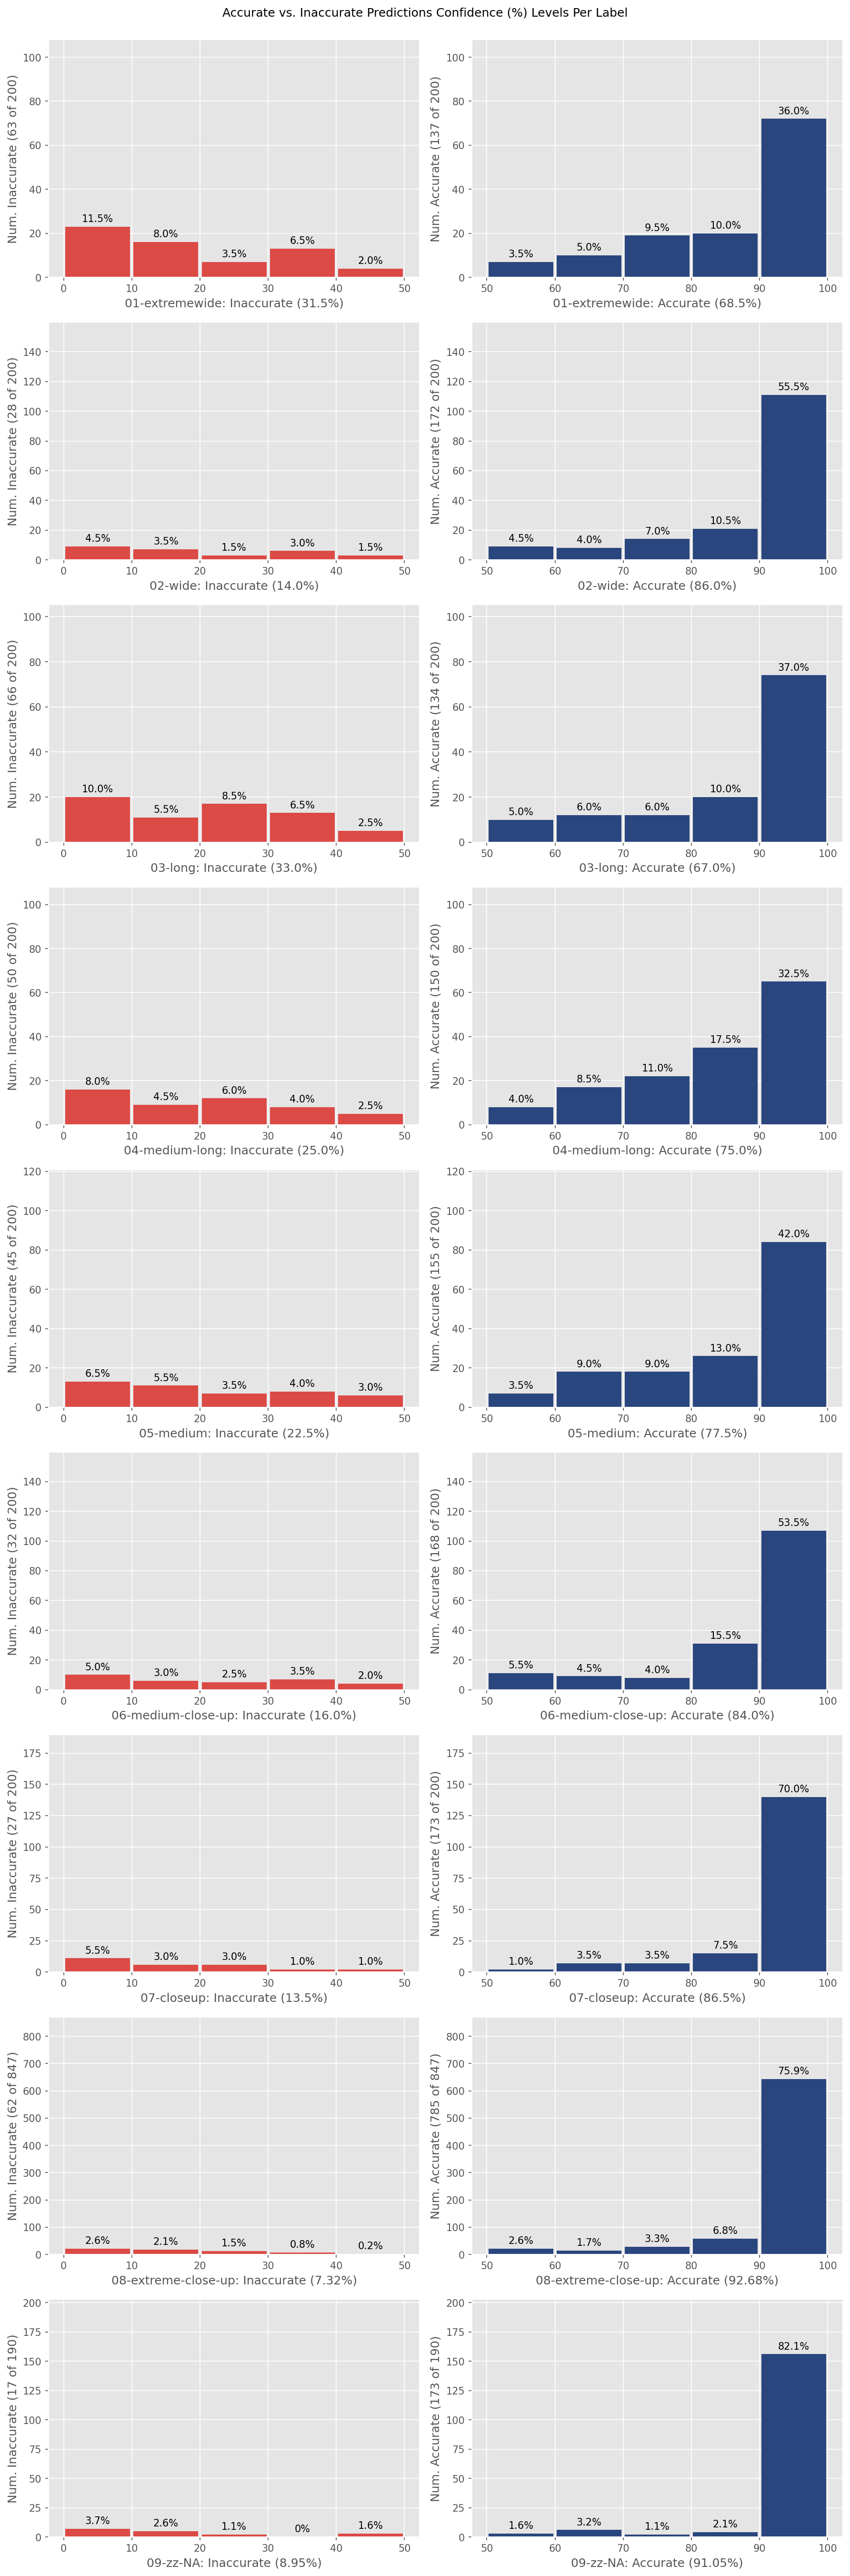

In [ ]:
interp.plot_label_confidence(bins=5)

### Plot Top Losses Grid

In [ ]:
#export
@patch
def plot_top_losses_grid(self:ClassificationInterpretationEx, k=16, ncol=4, largest=True,
                         font_path=None, font_size=12, use_dedicated_layout=True) -> PIL.Image.Image:
    """Plot top losses in a grid
    
    Uses fastai'a `ClassificationInterpretation.plot_top_losses` to fetch
    predictions, and makes a grid with the ground truth labels, predictions,
    prediction confidence and loss ingrained into the image
    
    By default, `use_dedicated_layout` is used to plot the loss (bottom),
    truths (top-left), and predictions (top-right) in dedicated areas of the
    image. If this is set to `False`, everything is printed at the bottom of the
    image
    """
    # all of the pred fetching code is copied over from
    # fastai's `ClassificationInterpretation.plot_top_losses`
    # and only plotting code is added here
    losses,idx = self.top_losses(k, largest)
    if not isinstance(self.inputs, tuple): self.inputs = (self.inputs,)
    if isinstance(self.inputs[0], Tensor): inps = tuple(o[idx] for o in self.inputs)
    else: inps = self.dl.create_batch(self.dl.before_batch([tuple(o[i] for o in self.inputs) for i in idx]))
    b = inps + tuple(o[idx] for o in (self.targs if is_listy(self.targs) else (self.targs,)))
    x,y,its = self.dl._pre_show_batch(b, max_n=k)
    b_out = inps + tuple(o[idx] for o in (self.decoded if is_listy(self.decoded) else (self.decoded,)))
    x1,y1,outs = self.dl._pre_show_batch(b_out, max_n=k)
    #if its is not None:
    #    _plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), self.preds[idx], losses,  **kwargs)
    plot_items = its.itemgot(0), its.itemgot(1), outs.itemgot(slice(len(inps), None)), self.preds[idx], losses
    def draw_label(x:TensorImage, labels):
        return PILImage.create(x).draw_labels(labels, font_path=font_path, font_size=font_size, location="bottom")
    # return plot_items
    results = []
    for x, truth, preds, preds_raw, loss in zip(*plot_items):
        if self.is_multilabel:
            truth = ';'.join(truth)
            preds = preds[0]
        probs_i = np.array([self.dl.vocab.o2i[o] for o in preds])
        pred2prob = [f"{pred} ({round(prob.item()*100,2)}%)" for pred,prob in zip(preds,preds_raw[probs_i])]
        if use_dedicated_layout:
            # draw loss at the bottom, preds on top-right
            # and truths on the top
            img = PILImage.create(x)
            top = []
            top.append("TRUTH: ")
            top.append(truth)
            pred2prob.insert(0, 'PREDS: ')
            loss_text = f"{'LOSS: '.rjust(8)} {round(loss.item(), 4)}"
            img.draw_labels(top,     location="top-left", font_size=font_size, font_path=font_path)
            img.draw_labels(pred2prob, location="top-right", font_size=font_size, font_path=font_path)
            img.draw_labels(loss_text, location="bottom", font_size=font_size, font_path=font_path)
            results.append(img)
        else:
            # draw everything at the bottom
            out = []
            out.append(f"{'TRUTH: '.rjust(8)} {truth}")
            bsl = '\n' # since f-strings can't have backslashes
            out.append(f"{'PRED: '.rjust(8)} {bsl.join(pred2prob)}")
            if self.is_multilabel: out.append('\n')
            out.append(f"{'LOSS: '.rjust(8)} {round(loss.item(), 4)}")
            results.append(draw_label(x, out))
    return make_img_grid(results, img_size=None, ncol=ncol)
    #for img,truth,pred_labels,preds_raw,loss in zip(x,y,)

In [ ]:
show_doc(ClassificationInterpretationEx.plot_top_losses_grid)

<h4 id="ClassificationInterpretationEx.plot_top_losses_grid" class="doc_header"><code>ClassificationInterpretationEx.plot_top_losses_grid</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>ClassificationInterpretationEx.plot_top_losses_grid</code>(**`k`**=*`16`*, **`ncol`**=*`4`*, **`largest`**=*`True`*, **`font_path`**=*`None`*, **`font_size`**=*`12`*, **`use_dedicated_layout`**=*`True`*)

```
Plot top losses in a grid

Uses fastai'a `ClassificationInterpretation.plot_top_losses` to fetch
predictions, and makes a grid with the ground truth labels, predictions,
prediction confidence and loss ingrained into the image

By default, `use_dedicated_layout` is used to plot the loss (bottom),
truths (top-left), and predictions (top-right) in dedicated areas of the
image. If this is set to `False`, everything is printed at the bottom of the
image
```

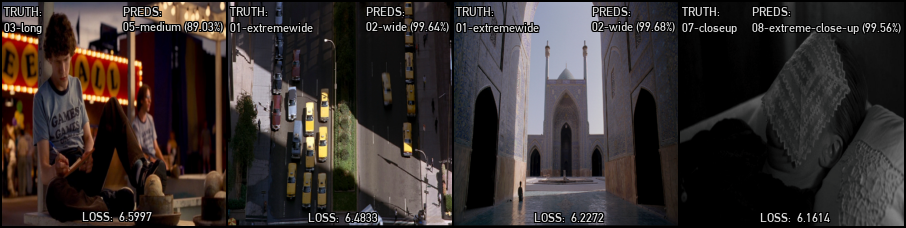

In [ ]:
interp.plot_top_losses_grid(k=4, ncol=4, font_path="../fonts/DIN Alternate Bold.ttf")

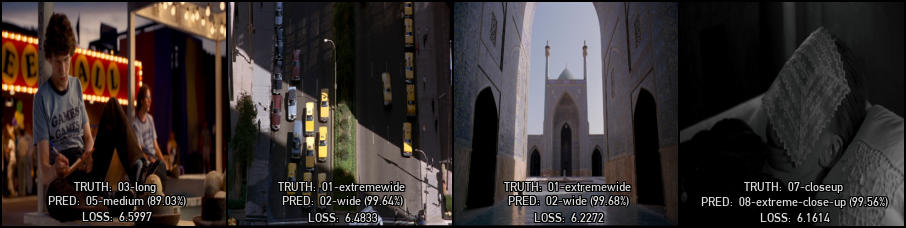

In [ ]:
interp.plot_top_losses_grid(k=4, use_dedicated_layout=False, font_path="../fonts/DIN Alternate Bold.ttf")

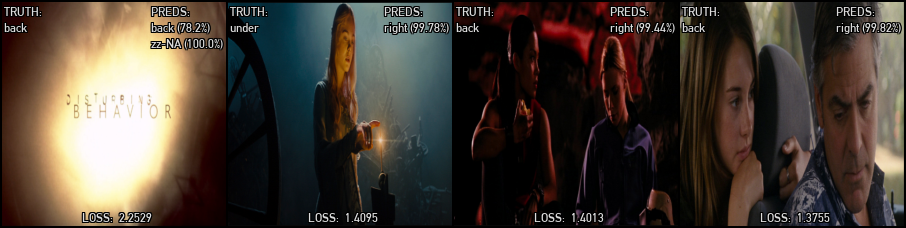

In [ ]:
interp_multi.plot_top_losses_grid(k=4, ncol=4, font_path="../fonts/DIN Alternate Bold.ttf")

### Classification Report

In [ ]:
#export
import sklearn.metrics as skm
@patch
def print_classification_report(self:ClassificationInterpretationEx, as_dict=False):
    "Get scikit-learn classification report"
    # `flatten_check` and `skm.classification_report` don't play
    # nice together for multi-label
    # d,t = flatten_check(self.decoded, self.targs)
    d,t = self.decoded, self.targs 
    if as_dict:
          return skm.classification_report(t, d, labels=list(self.vocab.o2i.values()), target_names=[str(v) for v in self.vocab], output_dict=True)
    else: return skm.classification_report(t, d, labels=list(self.vocab.o2i.values()), target_names=[str(v) for v in self.vocab], output_dict=False)

In [ ]:
print(interp.print_classification_report(as_dict=False))

                     precision    recall  f1-score   support

     01-extremewide       0.88      0.69      0.77       200
            02-wide       0.66      0.86      0.75       200
            03-long       0.76      0.67      0.71       200
     04-medium-long       0.74      0.75      0.75       200
          05-medium       0.75      0.78      0.76       200
 06-medium-close-up       0.85      0.84      0.85       200
         07-closeup       0.85      0.86      0.86       200
08-extreme-close-up       0.92      0.93      0.92       847
           09-zz-NA       0.95      0.91      0.93       190

           accuracy                           0.84      2437
          macro avg       0.82      0.81      0.81      2437
       weighted avg       0.85      0.84      0.84      2437



In [ ]:
from pprint import pprint
pprint(interp_multi.print_classification_report(as_dict=True))

{'back': {'f1-score': 0.6363636363636365,
          'precision': 0.5422535211267606,
          'recall': 0.77,
          'support': 100},
 'left': {'f1-score': 0.7265625,
          'precision': 0.5961538461538461,
          'recall': 0.93,
          'support': 100},
 'macro avg': {'f1-score': 0.6898334621773278,
               'precision': 0.5799271865870553,
               'recall': 0.895,
               'support': 550},
 'micro avg': {'f1-score': 0.6907574704656011,
               'precision': 0.5590551181102362,
               'recall': 0.9036363636363637,
               'support': 550},
 'right': {'f1-score': 0.7434944237918216,
           'precision': 0.591715976331361,
           'recall': 1.0,
           'support': 100},
 'samples avg': {'f1-score': 0.7317575757575757,
                 'precision': 0.6539393939393939,
                 'recall': 0.9036363636363637,
                 'support': 550},
 'top': {'f1-score': 0.6214285714285714,
         'precision': 0.48333333333333334

## Export

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script('interpret_classification-interpretation.ipynb')

Converted interpret_classification-interpretation.ipynb.
